## <font color=darkcyan> Probabilités numériques: Algorithme EM sur des chaines de Markov à données cachés (The Baum Welch Algorithm)</font>

Le but de ce projet est d'implémenter l'algorithme EM sur un modèle probabiliste ou les données obervables suivent des lois gaussiennes sachant les données cachés et où ces données cachés sont une chaine de Markov. Notre but sera donc d'approcher les probabilités de transitions de la chaines de Markov, les moyennes et variances des loi gaussiennes selon les différents états de la chaine et enfin les probabilités de la loi initiale de la chaine.

#### <font color=darkorange>Définition formelle du problème</font>

Plus formellement, soit $\left( X_k \right)_{ 1 \leq k \leq n}$ une chaine de Markov discrètes à valeurs dans $\left(\{1,....,r\} \right)$ de matrice de transition $Q$ et de loi initiale $\nu$. On considère que cette chaîne est uniquement observée au travers
des variables $\left(Y_k \right)_{ 1 \leq k \leq n}$ indépendantes conditionnellement à $\left( X_k \right)_{ 1 \leq k \leq n}$ et telle que pour tout
$\ 0 \leq l \leq n$
, la loi de $Y_l$ sachant $\left( X_k \right)_{ 1 \leq k \leq n}$ suit une loi $\mathcal{N}(\mu_{x_l}, v_{x_l})$
.
Le paramètre inconnu est donc ici $θ = \{\mu_{1}, . . . , ,\mu_{r}, v_{1}, . . . ,v_{r}, Q, \nu\}$.
 

In [2919]:
from graphviz import Digraph
import numpy as np
from scipy import stats
from numpy.random import default_rng
rng = default_rng()



#### <font color=darkorange>  - Etape E de l'Algorithme </font>

- Dans l'étape E de l'algorithme, le but est de calculer la quantité intermédiaire de l'EM à chaque étape t de l'algorithme:

    $$Q(\theta, \theta^t) =  \mathbb{E}_{\theta^t}[\log p_{\theta}(X_{0:n}, Y_{0:n})\mid Y_{0:n}]$$ 
    
    où $p_{\theta}$ est la densité du vecteur $(X_{0},...,X_{n},Y_{1},...,Y_{0})$. On peut commencer par écrire $\log p_{\theta}(X_{0:n}, Y_{0:n})$ en fonction des paramètres du problème.

    On sait que $\forall \theta$ et $\forall x_{0},..,x_{n},y_{0},..,y_{n} \in \mathbb{R}^{n+1} \times \{1,....,r\}^{n+1} $, on a  
    $$p_{\theta}(x_{0},..,x_{n},y_{0},..,y_{n}) = p_{\theta}(y_{0},..,y_{n} \mid x_{0},..,x_{n})  f^X_{\theta}(x_{0},..,x_{n})$$
     ou $f^X$ est la densité du vecteur $(X_{0},...,X_{n})$ .

    Or sachant $(X_{0},...,X_{n})$,  $(Y_{0},...,Y_{n})$ est un vecteur de variables aléatoire indépendantes, respectivement de loi $\mathcal{N}(\mu_{x_k}, v_{x_k}), \forall k \in \{ 0, \ldots, n \}$ donc :

    $$p_{\theta}(y_{0},..,y_{n},\mid x_{0},..,x_{n}) = \prod_{k=0}^n \frac{1}{\sqrt{2\pi v_{y_i}}} \exp\left(-\frac{(y_k-\mu_{x_i})^2}{2v_{x_k}}\right) $$

    On a aussi
     
    $$f^Y_{\theta}(x_{0},..,x_{n}) = \nu(x_{0})  \prod_{k=0}^{n-1} q_{x_k,x_{k+1}}$$

    On a donc 
    
    $$p_{\theta}(x_{0},..,x_{n},y_{0},..,y_{n}) = \nu(x_{0})\prod_{k=0}^n \frac{1}{\sqrt{2\pi v_{x_k}}} \exp\left(-\frac{(y_k-\mu_{x_k})^2}{2v_{x_k}}\right) \times \prod_{k=0}^{n-1} q_{x_k,x_{k+1}}$$

    donc
    
     $$\log p_{\theta}(X_{0:n}, Y_{0:n}) = \log(\nu(X_0)) + \sum_{k=0}^n \log\left(\frac{1}{\sqrt{2\pi v_{X_k}}}\right) - \sum_{k=0}^n \frac{(Y_k - \mu_{X_k})^2}{2v_{X_k}} + \sum_{k=0}^{n-1} \log(q_{X_k} q_{X_{k+1}})$$

    Enfin on touve 
    
    $$Q(\theta, \theta^\prime) = \mathbb{E}_{\theta '}[\log p_{\theta}(X_{0:n}, Y_{0:n})\mid Y_{0:n} = y_{0:n} ] $$ 
    
    $$ =\mathbb{E}_{\theta '}[\log(\nu^{\theta}(X_0)) + \sum_{k=0}^n \log\left(\frac{1}{\sqrt{2\pi v_{X_k}}}\right) - \sum_{k=0}^n \frac{(y_i - \mu^{\theta}_{X_k})^2}{2v^{\theta}_{X_k}} + \sum_{k=0}^{n-1} \log(q^{\theta}_{X_k X_{k+1}}) \mid Y_{0:n} = y_{0:n} ]$$
    
    $$=\mathbb{E}_{\theta '}[\log(\nu^{\theta}(X_0)) \mid Y_{0:n} = y_{0:n}] + \mathbb{E}_{\theta '}[\sum_{k=0}^n \log\left(\frac{1}{\sqrt{2\pi \nu^\theta_{X_k}}}\right) - \sum_{k=0}^n \frac{(y_k - \mu^{\theta}_{X_k})^2}{2v^{\theta}_{X_k}}\mid Y_{0:n} = y_{0:n}] + \mathbb{E}_{\theta '}[\sum_{k=0}^{n-1} \log(q^{\theta}_{X_k X_{k+1}})\mid Y_{0:n} = y_{0:n}]$$
     
    $$= \sum_{i=1}^{r} \log(v^{\theta}(i)) P_{\theta '}(X_0=i \mid Y_{0:n} = y_{0:n}) - 
     \sum_{i=0}^r\sum_{k=0}^n (\log\left(\frac{1}{\sqrt{2\pi \nu^\theta_{i}}}\right) - \frac{(y_k - \mu^{\theta}_{i})^2}{2v^{\theta}_{i}}) P_{\theta '}(X_k=i \mid Y_{0:n} = y_{0:n}) + \sum_{i=0}^r \sum_{j=0}^r \sum_{k=0}^{n-1} \log(q^{\theta}_{i j}) P_{\theta '}(X_k=i, X_{k+1}=j \mid Y_{0:n} = y_{0:n})$$ 



    $\underline{Conclusion}$ : 


    $$\boxed{ \mathbb{E}_{\theta '}[\log p_{\theta}(X_{0:n}, Y_{0:n})\mid Y_{0:n} = y_{0:n} ]= \sum_{i=1}^{r} \log(\nu^{\theta}(i)) \omega^{\theta\prime}_{0}(i) - 
    \sum_{i=0}^r\sum_{k=0}^n \left(\log\left(\frac{1}{\sqrt{2\pi v^\theta_{i}}}\right) - \frac{(y_k - \mu^{\theta}_{i})^2}{2v^{\theta}_{i}} \right) \omega^{\theta\prime}_{k}(i)+ \sum_{i=0}^r \sum_{j=0}^r \sum_{k=0}^{n-1} \log(q^{\theta}_{i j}) \omega^{\theta\prime}_{k,k+1}(i,j)} $$ 
    

#### <font color=darkorange>  - Etape M de l'Algorithme </font>

- Dans l'étape M de l'algorithme, le but est de maximiser la quatité intermédiaire : c'est à dire de trouver $\theta^{(t+1)} = \mathrm{argmax}_\theta Q(\theta,\theta^{(t)})$. 
 

    En déterminant où s'annulent les dérivées partiels et grâce aux multiplicateurs de lagranges, on obtient la mise à jour et donc $\theta^{(k+1)}$:
    
    
    - $\forall i,j \in \{1,...,r\}^2, \hspace{1.5cm} \boxed{q^{\theta^{t+1}}_{ij} = \frac{\sum_{k=0}^n \omega_{k,k+1}^{\theta^t}(i,j)}{\sum_{k=0}^n \omega_k^{\theta^t}(i)}}$

    - $\forall i \in \{1,...,r\}, \hspace{2cm} \boxed{\mu^\theta_{i} = \frac{\sum_{k=0}^n y_k w_{k}^{\theta'}(i)}{\sum_{k=0}^n w_{k}^{\theta'}(i)}}$
    
    $\hspace{5cm} \boxed{v^\theta_{i} = \frac{\sum_{k=0}^n (y_k - \mu^\theta_i)^2 \omega ^{\theta^{old}}_{k}(i)}{\sum_{k=0}^n w_{k}^{\theta'}(i)}}$

    $\hspace{5cm} \boxed{\nu^\theta_{i} = \omega ^{\theta^{old}}_{0}(i)}$

    Maintenant que nous avons nos mises à jours, il nous faut des méthodes pour calculer ou approcher les probabilités $\omega_{k,k+1}^{\theta'}(i,j)$ et 
    $\omega_k^{\theta'}(i)$.
    Il existe des algorithmes capables d'approchers ces valeurs :
    

    $$\omega_{k}^{\theta'}(i)=P_{\theta '}(X_k=i \mid Y_{0:n} = y_{0:n}) = \frac{ P_{\theta'}(X_k = i, Y_{0:n} = y_{0:n})}{P_{\theta'}(Y_{0:n} = y_{0:n})}$$



    $$\omega_{k,k+1}^{\theta'}(i,j)=P_{\theta '}(X_k=i, X_{k+1}=j \mid Y_{0:n} = y_{0:n}) = \frac{ P_{\theta'}(X_k = i, X_{k+1} = j, Y_{0:n} = y_{0:n})}{P_{\theta'}(Y_{0:n} = y_{0:n})}$$ 



    Pour estimiter ces quantités, on utilise des algorithmes récursifs appelé forward procedure et backward procedure.


   On introduit,$\forall t$ et $\forall i$, les quantités :
   
    $$\alpha_i(t) = \mathrm{P}(Y_1 = y_1, \ldots, Y_t = y_t, X_t = i | \theta)$$
    $$\beta_i(n) = P(Y_{t+1} = y_1, \ldots, Y_n = y_n,| X_t = i, \theta)$$
    $$ b_i(y_k)  = P(Y_k = y_k | X_k = i, \theta)$$
    
    
    Dans le cas discret cela fonctionnerait sauf que la quantité $b_i(y_k)$ donne toujours 0 car les observations sont continues. 
    Nous allons donc supposer par abus de langague que $b_i(y_k) = \int_{y_k-\epsilon}^{y_k+\epsilon} f_{Y_k|X_k = i}(y) \,dy$ pour epsilon assez petit envirion $\epsilon = 0.01$ .

   et on obtient finalement:

   $$\boxed{\omega_{k}^{\theta'}(i) = \frac{\alpha_i(k) \beta_i(k)}{\sum_{j=0}^r \alpha_j(k) \beta_j(k)}}$$

   $$\boxed{ \omega_{k,k+1}^{\theta'}(i,j) = \frac{\alpha_i(k) a_{ij} b_{{j}}(y_{k+1}) \beta_{j}(k+1)}{\sum_{i=1}^r \sum_{w=1}^r \alpha_i(k) a_{iw}  b_{{w}}(y_{k+1}) \beta_{w}(k+1)}}$$

   Pour calculer les quantité $\alpha_i(k)$ et  $\beta_i(k)$, on utilise les algorithmes récursif forward et backward suivant:

   - $\textit{Initalisation:} $

   $$ \forall i, \alpha_i(1) = \pi_i b_i(y_1)$$

   - $\textit{Récursion:}$

   $$\alpha_{i}(k+1) = \left[\sum_{j=1}^r \alpha_{j}(k)a_{ij}\right]b_i(y_{k+1})$$

   - $\textit{Initalisation:}$
   
  $$\forall i, \beta_i(n) = 1 $$

   - $\textit{Récursion:}$

   $$\beta_i(k) = \sum_{j=1}^r a_{ij}b_j(y_{k+1})\beta_{j}(k+1)$$

   On pose la matrice alpha de taille $n\times r$ tel que $a_{ki} = \alpha_{i}(k)$
   et la matrice b de taille $n\times r$ tel que $b_{ki} = b_{i}(k)$

   Par ailleurs on a besoin de ces initalisations pour que la récursion soit juste. 
   Ces récursions sont logique - > annexe


 
 

#### <font color=darkorange>  - Partie application et execution de l'algorithme EM </font>

#### <font color=darkorange>  I - Simulations des obervations </font>




Notre but va donc être de fixer les paramètres de $\theta$ de notre modèle et simuler des observations sous ce theta fixé. Nous allons ensuite vérifier que notre algorithme EM approxime bien nos paramètres de theta en supposant connues seulement les observations.

<font color=red> - Simulation de n observations d'une chaine de markov de matrice de transition Q, loi initiale v et espace d'états E. </font>

In [2920]:
""" Simulation est une fonction qui simule n_steps pas d'une chaine de markov sur un espace détat e, de loi initiale nu, de matrice de transition Q"""
def Simulation(Q,nu,e,n_steps): 
    # Q : matrice de transition (array de float dimension  r * r) 
    # nu :  loi initiale (array de float dimension r) 
    # e : liste_d'etats (array de int dimension r)
    #n_steps : nombre de pas de la chaines à simuler (int)

    X = np.zeros(n_steps,dtype = np.int64)
    current_state = rng.choice(e,p = nu)
    for i in range(n_steps): 
        X[i] = current_state
        current_state = rng.choice(e,p = Q[current_state - 1])
    return X


In [2921]:
""" Simulation observations est une fonction qui simule les obersvations Yi sachant les états Xi d'une chaine de markov sur un espace détat e, 
de loi initiale nu, de matrice de transition Q, de moyennes des etats means et variance vars"""


def Simulation_Observation(chaine_states,means,vars):  
    # chaine_states -> etats de la chaine pour simuler les observations -> array de int
    # means - > liste des mean_x (float)
    # var -> liste des var_x (float)
    
    Y = np.zeros(chaine_states.size,dtype = np.float64)
    for i in range(chaine_states.size): 
        normale_i = stats.norm(loc = means[chaine_states[i] - 1], scale = np.sqrt(vars[chaine_states[i] - 1]))
        Y[i] = normale_i.rvs()
    return Y


#### <font color=darkorange>  II - Calcul des quantités omegas </font>




<font color=red>  - Calcul de la matrice B </font>

Notre matrice B sera de la forme : 

\begin{pmatrix}
b_1(y_1) & b_2(y_1) & b_r(y_1) \\
b_1(y_2) & b_2(y_2) & b_r(y_2) \\
.      &   .    &   .    \\
b_1(y_n) & b_2(y_n) & b_r(y_n) \\

\end{pmatrix}


In [2922]:
""" create_B est une fonction qui crée la matrice B des paramètres acutels de l'EM grâce à la formule de récurrence """

def create_B(Y,means,vars):
    # Y -> observations
    # means -> moyennes des etats
    # vars -> variances des etats
    
    n = Y.size
    r = means.size 
    B = np.zeros([n,r],dtype = np.float64) # matrice B
    for i in range(r):
        normal_law = stats.norm(loc = means[i], scale = np.sqrt(vars[i]))
        B[:,i] = normal_law.pdf(Y) # valeur de la densité en y
        #B[:,i] = np.log(normal_law.pdf(Y)) # valeur de la densité en y
        #B[:,i] = B[:,i] / np.sum(B[:,i]) # normalisation sur la colonne
        #print(sum(B[:,i]))
    #print(f"B = {B}")
    return B

eps = 0.01 

"""def create_B(Y,means,vars):
    n = Y.size
    r = means.size 
    B = np.zeros([n,r],dtype = np.float64)
    for i in range(r):
        normal_law = stats.norm(loc = means[i], scale = np.sqrt(vars[i]))
        B[:,i] = normal_law.cdf(Y+eps) - normal_law.cdf(Y-eps)
    return B"""

'def create_B(Y,means,vars):\n    n = Y.size\n    r = means.size \n    B = np.zeros([n,r],dtype = np.float64)\n    for i in range(r):\n        normal_law = stats.norm(loc = means[i], scale = np.sqrt(vars[i]))\n        B[:,i] = normal_law.cdf(Y+eps) - normal_law.cdf(Y-eps)\n    return B'

<font color=red>  - Calcul de la matrice Alpha </font>

Notre matrice $\alpha$ est de la forme : 

\begin{pmatrix}
\alpha_1(1) & \alpha_2(1) & \alpha_r(1) \\
\alpha_1(2) & \alpha_2(2) & \alpha_r(2) \\
.      &   .    &   .    \\
\alpha_1(n) & \alpha_2(r) & \alpha_r(n) \\

\end{pmatrix}


In [2923]:
def create_alpha(Y,theta):

    Q,nu,means,vars = theta
    
    """ create_alpha est une fonction qui crée la matrice alpha 
    des paramètres acutels de l'EM grâce à la formule de récurrence """

    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats

    n = Y.size # nombre d'obeservations
    r = means.size # nombre d'états
    B = create_B(Y,means,vars) # matrice beta
    A = np.zeros([n,r]) # matrice alpha
    A[0,:] = nu * B[0,:]
    for k in range(1,n):
        for i in range(r):
            A[k,i] = (A[k-1,:] @ Q[:,i]) * B[k,i] #reccurrence
        #A[k,:] = A[k,:] / np.sum(A[k,:]) #rescaling
        #A[k,i] = np.log(A[k,i]) - 

    #print(f"A = {A}")
    return A

<font color=red>  - Calcul de la matrice Beta </font>

Notre matrice $\beta$ est de la forme : 

\begin{pmatrix}
\beta_1(1) & \beta_2(1) & \dots & \beta_r(1) \\
\beta_1(2) & \beta_2(2) & \dots & \beta_r(2) \\
\vdots      & \vdots      & \ddots & \vdots      \\
\beta_1(n) & \beta_2(r) & \dots & \beta_r(n) \\

\end{pmatrix}

In [2924]:
def create_beta(Y,theta):

    Q,nu,means,vars = theta

    """ create_beta est une fonction qui crée la matrice 
    B des paramètres acutels de l'EM grâce à la formule de récurrence """

    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats
    
    n = Y.size # nombre d'observations
    r = nu.size # nombre d'états
    B = create_B(Y,means,vars)  # matrice B  
    beta = np.zeros([n,r]) # matrice beta
    beta[-1,:] = np.ones(r)

    for k in range(n-2, -1, -1):
        for i in range(r):
            beta[k,i] = np.sum(beta[k+1,:] * B[k+1,:] * Q[i,:]) # reccurrence
            #beta[k,i] = np.log(beta[k,i])
        #beta[k,:] = beta[k,:] / np.sum(beta[k,:]) # rescaling
    #print(f" Beta = {B}")
    return beta

<font color=red>  - Calcul des matrices Omega </font>

Nos matrices $\omega$ sont de la forme : 

La matrice des $\omega_k(i)$

\begin{pmatrix}
\omega_1(1) & \omega_2(1) & \dots & \omega_r(1) \\
\omega_1(2) & \omega_2(2) & \dots & \omega_r(2) \\
\vdots      & \vdots      & \ddots & \vdots      \\
\omega_1(n) & \omega_2(r) & \dots & \omega_r(n) \\

\end{pmatrix}

la seconde matrice des $\omega_{k,k+1}(i)$ est une liste de matrice de la forme:

$$
\begin{bmatrix}
    \begin{pmatrix}
        \omega_{1,2}(1,1) & \omega_{1,2}(1,2) & \dots & \omega_{1,2}(1,3) \\
        \omega_{1,2}(2,1) & \omega_{1,2}(2,2) & \dots & \omega_{1,2}(2,3) \\
        \vdots      & \vdots      & \ddots & \vdots      \\
        \omega_{1,2}(r,1) & \omega_{1,2}(r,2) & \dots & \omega_{1,2}(r,r) \\
    \end{pmatrix}, \dots ,
    &
    \begin{pmatrix}
        \omega_{n-1,n}(1,1) & \omega_{n-1,n}(1,2) & \dots & \omega_{n-1,n}(1,3) \\
        \omega_{n-1,n}(2,1) & \omega_{n-1,n}(2,2) & \dots & \omega_{n-1,n}(2,3) \\
        \vdots      & \vdots      & \ddots & \vdots      \\
        \omega_{n-1,n}(r,1) & \omega_{n-1,n}(r,2) & \dots & \omega_{n-1,n}(r,r) \\
    \end{pmatrix}
\end{bmatrix}
$$


In [2925]:
def omega_now(Y,theta):   

    Q,nu,means,vars = theta

    """ omega_now est une fonction qui permet de calculer les coefficient omega"""

    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats
 
    n = Y.size # nombre d'observations
    r = nu.size # nombre d'états
    omega = np.zeros([n,r]) # matrice omega
    alpha = create_alpha(Y,theta) # matrice alpha
    beta = create_beta(Y,theta) # matrice beta
    print(beta)
    for k in range(n):
        for i in range(r):
            omega[k,i] = (alpha[k,i] * beta[k,i])
            #print(alpha[k,i])
            #print(beta[k,i])
            #print(f" a*b = {alpha[k,i] * beta[k,i]} ")
            #print(f" log(*ab) = {np.log(alpha[k,i] * beta[k,i])}")
            #print(f"omega_k_i = {omega[k,i]}")
            #omega[k,i] = np.log(alpha[k,i]) + np.log(beta[k,i])
        print(f"alpha[{k},:] = {alpha[k,:]}")
        print(f"beta[{k},:] = {beta[k,:]}")
        #print(f"OKKK = {np.sum(omega[k,:])}")
        if(np.sum(omega[k,:]) != 0 ):
            print(f"see = {np.sum(omega[k,:])}")
            omega[k,:] = omega[k,:] / np.sum(omega[k,:]) # rescaling
        else:
            omega[k,:] = 0
    print(omega)

    return omega



In [2926]:
def omega_next(Y,theta):   
    
    Q,nu,means,vars = theta

    """ omega_now est une fonction qui permet 
    de calculer les coefficient omega"""

    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu -> loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats

    n = Y.size # nombre d'observations
    r = nu.size   # nombre d'états
    alpha = create_alpha(Y,theta) # matrice alpha
    beta = create_beta(Y,theta) # matrice beta
    B = create_B(Y,means,vars) # matrice B
    N = Q.shape[0]
    omega = np.zeros((n-1,N,N))  # matrice omega

    for k in range(n-1):
        for i in range(r):
            for j in range(r):
                omega[k,i,j] = np.log(alpha[k,i] * Q[i,j] * B[k+1,j]  * beta[k+1,j]) # reccurence
        omega[k, :, :] = omega[k, :, :] / np.sum(omega[k, :, :]) # rescaling
    return omega

<font color=red> - Très important !!! Le rescaling </font>

Première approximation, les betas....

Le rescaling est une étape importante de l'algorithme EM pour les modèles de Markov Caché.

L'étape E de l'algorithme EM consiste à calculer la distribution des variables cachées $X_1, X_2, ..., X_n$ conditionnellement aux données observées $Y_1, Y_2, ..., Y_n$ et aux paramètres courants $\theta^{(t)}$, où $t$ est le numéro d'itération actuel de l'algorithme. Cette distribution conditionnelle peut être calculée à l'aide de l'algorithme de Forward-Backward.

Cependant, pour éviter les problèmes numériques d'underflow ou d'overflow, il est nécessaire de renormaliser les probabilités obtenues par l'algorithme de Forward-Backward. En effet, les probabilités de \alpha, \beta et b  peuvent être très petites ou très grandes, et lorsqu'on multiplie plusieurs probabilités ensemble, les résultats peuvent rapidement devenir imprécis.

Le rescaling consiste donc à renormaliser les probabilités obtenues dans l'algorithme de Forward-Backward pour chaque instant $k$ de la chaîne de Markov cachée, de telle sorte que la somme des probabilités pour chaque état soit égale à 1. Cela permet de maintenir une précision numérique suffisante pour les calculs ultérieurs.

On renormalise donc non seulement les alpha, mais aussi les beta, nous considérerons donc toujours dorénavant les alpha_chapeau, beta chapeau...

#### <font color=darkorange>  III - Implémentation de l'algo EM </font>

Dans cette partie, on code l'algorithme EM d'abord en mettant seulement à jours, la moyenne puis la variance. On test cette algorithme pour 3 modèles simples et on vérifie qu'on a bien augmentation de la vraissemblance. On compare aussi la convergence de l'EM pour différents paramètres initiales et un nombre différents d'observations.


#### <font color=pink> MODIFICATION </font>


On calcule la vraissemblance sachant des données cachées car la vraissemblance des observations est trop compliqué à calculer, c'est la somme sur toutes les possibiltiés de transtions de la chaines des ..., et comme nous connaisons justement les données cachées dans nos exemples il n'y pas de problèmes.
 $$ \log p_\theta(Y_1=y_1,\dots,Y_n=y_n| X_1 = x_1 \dots, X_n = x_n) = \nu(x_{0})\prod_{k=0}^n \frac{1}{\sqrt{2\pi v_{x_k}}} \exp\left(-\frac{(y_k-\mu_{x_k})^2}{2v_{x_k}}\right) $$


In [2927]:
"""def Q_fun(Y,theta,theta_prime):

    print("ok")
    
    Q1,nu1,means1,vars1 = theta_prime
    Q2,nu2,means2,vars2 = theta
    
    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats

    n = Y.size # nombre d'obeservations
    r = means1.size # nombre d'états
    omega1 = omega_now(Y,theta_prime)
    omega1_after = omega_next(Y,theta_prime)

    print("ok")

    sum1 = 0
    sum2 = 0
    sum3 = 0

    for i in range(r):
        sum1 = np.log(nu2[i]) * omega1[0,i]

    for i in range(r):
        for k in range(n):
            sum2 = sum2 + np.log(stats.norm.pdf(Y[k],loc = means2[i], scale = np.sqrt(vars2[i]) ) ) * omega1[k,i]

    for i in range(r):
        for j in range(r):
            for k in range(n-1):
                sum3 = sum3 + np.log(Q1[i,j]) * omega_after[k,i,j]

    
    return sum1 - sum2"""


'def Q_fun(Y,theta,theta_prime):\n\n    print("ok")\n    \n    Q1,nu1,means1,vars1 = theta_prime\n    Q2,nu2,means2,vars2 = theta\n    \n    # Y -> observations\n    # Q -> matrice de transitions de la chaine de markov\n    # nu loi initiale de la chaine\n    # means -> moyennes des etats\n    # vars -> variances des etats\n\n    n = Y.size # nombre d\'obeservations\n    r = means1.size # nombre d\'états\n    omega1 = omega_now(Y,theta_prime)\n    omega1_after = omega_next(Y,theta_prime)\n\n    print("ok")\n\n    sum1 = 0\n    sum2 = 0\n    sum3 = 0\n\n    for i in range(r):\n        sum1 = np.log(nu2[i]) * omega1[0,i]\n\n    for i in range(r):\n        for k in range(n):\n            sum2 = sum2 + np.log(stats.norm.pdf(Y[k],loc = means2[i], scale = np.sqrt(vars2[i]) ) ) * omega1[k,i]\n\n    for i in range(r):\n        for j in range(r):\n            for k in range(n-1):\n                sum3 = sum3 + np.log(Q1[i,j]) * omega_after[k,i,j]\n\n    \n    return sum1 - sum2'

In [2928]:
def log_vraissemblance_observations(Y,theta): 
    from itertools import product

    Q,nu,means,vars = theta
    """ fonction qui permet de calculer la log vraissemblance 
    sachant les etats de la chaine """
    
    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats

    n = Y.size # nombre d'observations
    r = means.size   # nombre d'états
    states = list(np.arange(r))
    means_cartesien = [states for i in range(n)]
    result = list(product(*means_cartesien))
    print(result)
    s = 0
    densite_produit = 1
    proba_produit = 1
    for l in range(len(result)):
        for k in range(n):
            normal = stats.norm(loc = means[result[l][k]], scale = vars[result[l][k]] )
            densite_produit = densite_produit * normal.pdf(Y[k])
        densite_produit = densite_produit * nu[result[l][0]]

        for k in range(n-1):
            proba_produit = proba_produit * Q[result[l][k],result[l][k+1]]

        result = result + densite_produit * proba_produit

 
    return densite_produit*proba_produit

In [2929]:
def log_likelihood_observations(Y,states,means,vars): 
    from itertools import product


    """ fonction qui permet de calculer la log vraissemblance 
    sachant les etats de la chaine """
    
    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats

    n = Y.size # nombre d'observations
    log_likelihood = 0
    for k in range(n):
        normale = stats.norm(loc = means[states[k]-1], scale = np.sqrt(vars[states[k]-1]))
        log_likelihood = log_likelihood + np.log(normale.pdf(Y[k]))
    
    return log_likelihood

In [2930]:
def EM_test_simple(Y,theta_init,nb_iters,states = []):
    

    Q_init,nu_init,means_init,vars_init = theta_init
    """cette fonction calcule n_iters itérations de l'algorithme EM avec
    comme paramatètres initiales means_init et vars_init"""

    # Y -> observations
    # Q_init -> matrice de transitions de la chaine de markov
    # nu_init -> loi initiale de la chaine
    # means_init -> moyennes des etats
    # vars_init -> variances des etats

    n = Y.size # nombre d'observations
    r = nu_init.size  # nombre d'états
    y = Y # liste d'observations
    Q = Q_init # matrice de transtion
    nu = nu_init # liste de loi initiale
    means = means_init # moyenne à itérer
    vars = vars_init # variance à itérer
    liste_means = [] # liste des moyennes succesives
    liste_vars = [] # liste des variances successives
    log_likelihood = log_likelihood_observations(Y,states,means,vars)


    for i in range(nb_iters):
        theta_prime = (Q,nu,means,vars)
        omega = omega_now(y,theta_prime) # mise à jour de omega
        liste_means.append(np.array(means)) 
        liste_vars.append(np.array(vars))
        for j in range(r):
            means[j]  = np.sum(y*omega[:,j]) / np.sum(omega[:,j]) # mise à jour des moyennes 
            vars[j]  = np.sum(((y - means[j])**2) * omega[:,j]) / np.sum(omega[:,j]) # mises à jours des variances
        theta = (Q,nu,means,vars)
        #print(Q_fun(y,theta,theta_prime))
    return means,vars,np.array(liste_means),np.array(liste_vars)

<font color=red> - Test pour différents modèles et comparaisons en fonction du nombres d'observations, itérations, conditions initales</font>

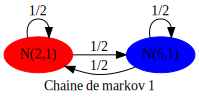

In [2931]:
from graphviz import Digraph

# créer le graphe
dot = Digraph(comment='Chaines de Markov')
dot.attr(label='Chaine de markov 1')
dot.attr(rankdir='LR') # orientation horizontale

# ajouter les états
dot.node('N(2,1)', style='filled', color='red')
dot.node('N(6,1)', style='filled', color='blue')

# ajouter les transitions
dot.edge('N(2,1)', 'N(2,1)', label='1/2')
dot.edge('N(2,1)', 'N(6,1)', label='1/2')
dot.edge('N(6,1)', 'N(6,1)', label='1/2')
dot.edge('N(6,1)', 'N(2,1)', label='1/2')

# afficher le graphe
dot.graph_attr['size'] = '5,3'
dot.render('markov_chain', format='png', view=True)
dot


In [2932]:
""" Chaine de markov 1 """

Q = np.array([[1/2,1/2],[1/2,1/2]])
nu = np.array([1/2,1/2])
E = np.array([1,2])
nb_observations = 50
means = np.array([2,6])
vars = np.array([1,1])

X = Simulation(Q,nu,E,nb_observations)
Y = Simulation_Observation(X,means,vars)

means_init = np.array([3.,8.])
vars_init = np.array([0.5,0.5])
nb_iters = 20

theta_init = (Q,nu,means_init,vars_init)

"""un exemple intéressant"""

"""X = np.array([1,2,2,2,2,2,1,2,2,1,1,2,2,1,2,1,1,1,2,2,1,1,1,2,2,1,1,2,1,1,1,2,2,2,
     1,2,1,2,1,1,2,1,1,2,1,2,1,1,1,1,1,1,2,1,2,1,2,2,2,2,2,1,1,1,2,1,
    1,2,1,1,1,2,2,2,1,1,2,1,1,2,2,2,1,2,2,1,2,1,1,2,1,1,2,2,1,1,1,2,1,1])

Y = np.array([2.00507166,4.93525412,7.43497409,6.36283977,4.81479766,5.35323261,1.38207206,
    6.44645047,4.09265859,4.14828342,0.96036471,5.80476562,6.02238843,2.0109842,4.41429409,
    3.45349381, 1.98167004,2.71854784,5.86145922,6.65690703,1.75656305,1.71248614,4.0086468,6.14413115,
     4.69130214,1.70794374,3.44157134,7.41007541,1.44177348,0.59716546,3.67167445,6.06766682,
     6.15358134,5.27320699,2.63512393,6.44490706,3.54174975,7.11488516,1.58119388,1.25552937,
     6.11572732,1.3230229,0.10894554,6.69278762,2.32048959,6.57133935,1.56684187,-0.10369138,
     1.97134623,3.16665628,2.45299993,1.74684063,4.82238665,2.41507313,5.01964289,1.2383916,
     5.74755794,4.47596849,5.05257713,5.04389432,5.85513106,3.30285652,1.26960582,1.71424008,
     6.53669445,2.68661603,2.5151611,6.17978801,2.29264643,-0.60699086,2.00580995,6.67475459,
     6.33342314,3.42503878,2.45194502,0.98687447,5.72618427,1.3823361,1.58608607,6.10573376,
     4.9974734,6.36745436,2.06057361,5.48139311,4.3265302,2.66765835,5.7892255,3.0093004,
     3.20332881,5.15445079,1.95489352,2.64264339,7.85960945,6.42729427,2.19144384,2.2647161,
     2.50172035,6.45628348,0.91577052,1.57958277])"""


means_result,vars_result,liste_means,liste_vars = EM_test_simple(Y,theta_init,nb_iters,X)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")

[[6.27339070e-75 6.27339070e-75]
 [3.49764534e-73 3.49764534e-73]
 [1.79612203e-70 1.79612203e-70]
 [3.63983184e-69 3.63983184e-69]
 [2.85927151e-66 2.85927151e-66]
 [1.68414998e-65 1.68414998e-65]
 [8.94353489e-64 8.94353489e-64]
 [7.29179088e-63 7.29179088e-63]
 [2.20233914e-60 2.20233914e-60]
 [1.08140891e-58 1.08140891e-58]
 [7.25582179e-58 7.25582179e-58]
 [2.84978896e-57 2.84978896e-57]
 [1.21036408e-56 1.21036408e-56]
 [3.48326149e-54 3.48326149e-54]
 [1.42124593e-51 1.42124593e-51]
 [5.06321471e-51 5.06321471e-51]
 [2.26982948e-48 2.26982948e-48]
 [3.03934440e-47 3.03934440e-47]
 [8.74858673e-45 8.74858673e-45]
 [3.80999144e-44 3.80999144e-44]
 [5.37878084e-43 5.37878084e-43]
 [2.34762306e-42 2.34762306e-42]
 [2.29758057e-41 2.29758057e-41]
 [3.11248679e-40 3.11248679e-40]
 [5.79703820e-38 5.79703820e-38]
 [2.91000740e-35 2.91000740e-35]
 [3.49249928e-33 3.49249928e-33]
 [1.57538330e-31 1.57538330e-31]
 [1.34004132e-28 1.34004132e-28]
 [6.31535834e-28 6.31535834e-28]
 [4.811089

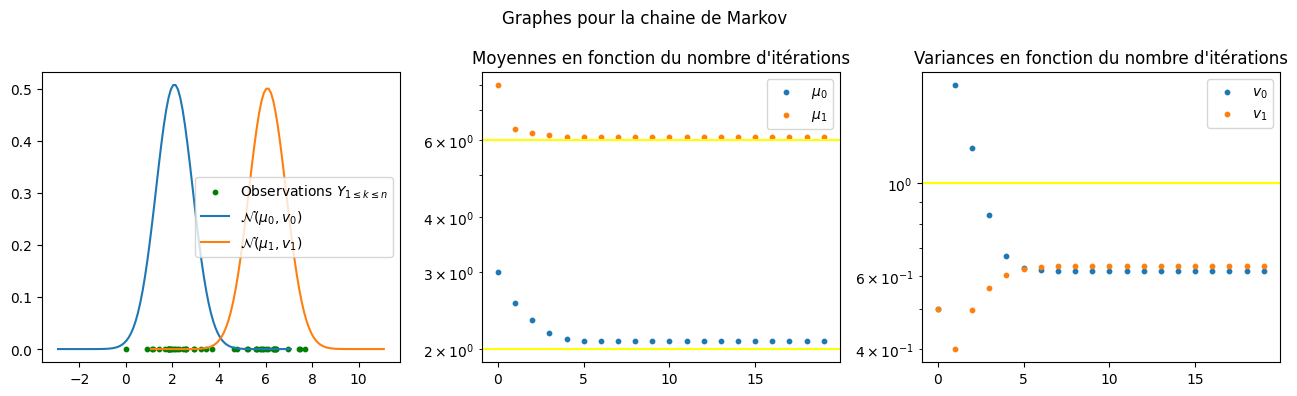

In [2933]:
"""Affichage pour la chaine de markov 1"""

import matplotlib.pyplot as plt
import seaborn as sns

def affichage(Y,means,vars,liste_means,liste_vars,nb_iters,real_means,real_vars):
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (13,4), layout = "tight")
    abs = np.zeros(Y.size)
    ax1.scatter(Y,abs,label = "Observations $Y_{ 1 \leq k \leq n}$", color = "green", s= 10)
    for k in range(means_result.size):
        normal_k = stats.norm(loc = means[k], scale = np.sqrt(vars[k]))
        abs_k = np.linspace(means[k]-5,means[k]+5,100)
        ax1.plot(abs_k,normal_k.pdf(abs_k),label = "$\mathcal{N}$" + f"$(\mu_{k}, v_{k})$")  
        ax1.legend()

    for k in range(means_result.size):
        ax2.scatter(np.arange(nb_iters),liste_means[:,k],label = f"$\mu_{k}$",s = 10 )
        ax2.axhline(real_means[k],color = "yellow")
        ax2.set_yscale('log')
        ax2.set_title("Moyennes en fonction du nombre d'itérations")

    ax2.legend()

    for k in range(means_result.size):
        ax3.scatter(np.arange(nb_iters),liste_vars[:,k],label = f"$v_{k}$", s = 10 )
        ax3.axhline(real_vars[k],color = "yellow")
        ax3.set_yscale('log')
        ax3.set_title("Variances en fonction du nombre d'itérations")

    ax3.legend()

    fig.suptitle("Graphes pour la chaine de Markov")
    plt.show()

affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)



#### <font color=pink> MODIFICATION </font>

Dans le cas de la chaine de markov 1, on a presque convergence vers les bons paramètres de moyenens... et variances...., avec pour conditions initales ... et nombre d'observations..., . La convergence de l'EM dépend des paramètres initiaux, mais aussi du nombre d'observations.
Remarquons que on a quand même toujours augemntation de la log vraissemblance.

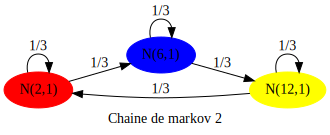

In [2934]:
from graphviz import Digraph

# créer le graphe
dot = Digraph(comment='Chaines de Markov')
dot.attr(label='Chaine de markov 2')
dot.attr(rankdir='LR') # orientation horizontale

# ajouter les états
dot.node('N(2,1)', style='filled', color='red')
dot.node('N(6,1)', style='filled', color='blue')
dot.node('N(12,1)', style='filled', color='yellow')

# ajouter les transitions
dot.edge('N(2,1)', 'N(6,1)', label='1/3')
dot.edge('N(6,1)', 'N(12,1)', label='1/3')
dot.edge('N(12,1)', 'N(2,1)', label='1/3')
dot.edge('N(2,1)', 'N(2,1)', label='1/3')
dot.edge('N(6,1)', 'N(6,1)', label='1/3')
dot.edge('N(12,1)', 'N(12,1)', label='1/3')

# afficher le graphe
dot.graph_attr['size'] = '5,3'
dot.render('markov_chain', format='png', view=True)

dot


[3 1 1 2 2 3 1 2 3 2 1 2 3 2 1 1 1 2 2 1 2 3 2 3 3 2 3 1 3 1 3 2 3 1 1 1 2
 1 3 2 3 1 3 3 2 1 2 2 2 3]
50
50
[[1.46223025e-104 1.46223025e-104 1.46223025e-104]
 [1.15872437e-103 1.15872437e-103 1.15872437e-103]
 [1.00811651e-102 1.00811651e-102 1.00811651e-102]
 [3.77901570e-101 3.77901570e-101 3.77901570e-101]
 [2.07125842e-099 2.07125842e-099 2.07125842e-099]
 [1.27314645e-095 1.27314645e-095 1.27314645e-095]
 [2.56244721e-093 2.56244721e-093 2.56244721e-093]
 [3.42381677e-092 3.42381677e-092 3.42381677e-092]
 [3.03400107e-086 3.03400107e-086 3.03400107e-086]
 [2.03581105e-084 2.03581105e-084 2.03581105e-084]
 [3.00272037e-083 3.00272037e-083 3.00272037e-083]
 [5.12418514e-082 5.12418514e-082 5.12418514e-082]
 [3.88818536e-081 3.88818536e-081 3.88818536e-081]
 [1.11990012e-079 1.11990012e-079 1.11990012e-079]
 [8.42290812e-079 8.42290812e-079 8.42290812e-079]
 [6.15266934e-077 6.15266934e-077 6.15266934e-077]
 [2.68172650e-075 2.68172650e-075 2.68172650e-075]
 [3.45414173e-074 3.4541

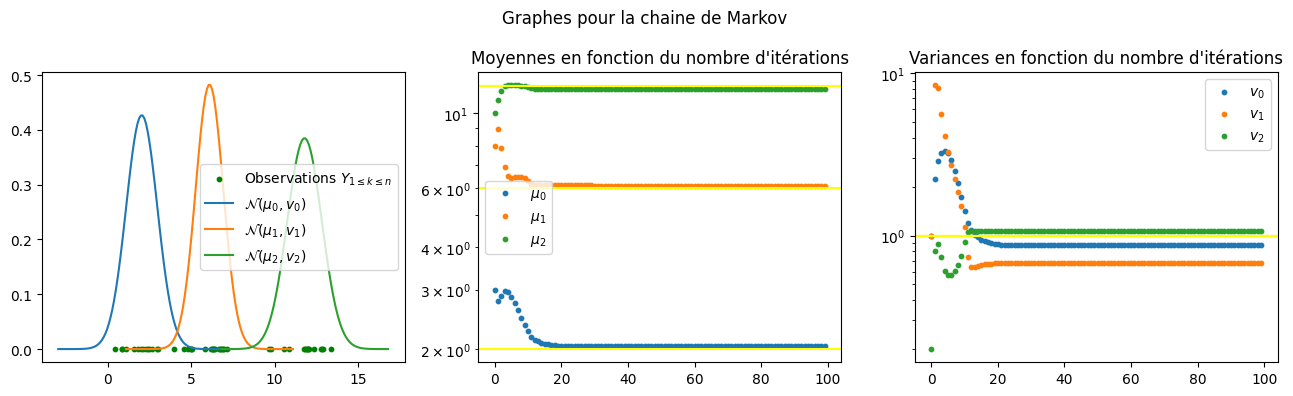

In [2935]:
""" Chaine de markov 2 """

Q = np.array([[1/3,1/3,1/3],[1/3,1/3,1/3],[1/3,1/3,1/3]])
nu = np.array([1/3,1/3,1/3])
E = np.array([1,2,3])
nb_observations = 50
means = np.array([2,6,12])
vars = np.array([1,1,1])
X = Simulation(Q,nu,E,nb_observations)
print(X)
Y = Simulation_Observation(X,means,vars)

""" un exemple intéressant """

means_init = np.array([3.,8.,10.])
vars_init = np.array([1.,1.,0.2])
nb_iters = 100

theta_init = (Q,nu,means_init,vars_init)


"""Y = np.array([11.71399004,6.0843945,10.23326564,7.97043982,1.28037653,5.60405363,12.63425272,5.8287776,
     2.62573921,10.3448865,2.67337835,5.87010154,10.76140134,10.80786926,13.13480434,12.04572743,
     2.86343034,12.56612367,4.60071295,1.62078419,2.77991203,-0.01558522,-0.29711457,7.06809974,
     12.03555501,2.27256961,6.82172416,6.6817702,1.27439161,7.39892503,12.82425527,1.00512637,
     0.16057977,3.26164898,4.92317264,10.47845169,5.86618054,5.1755427,12.9100759,12.20848328,
     3.96021627,3.05617011,12.85636277,10.11387745,11.81676142,7.48716132,1.27064752,3.09859839,
     12.5783242,0.91869878])

X = np.array([3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4])"""

print(len(Y))
print(len(X))
means_result,vars_result,liste_means,liste_vars = EM_test_simple(Y,theta_init,nb_iters,X)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")

affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)


[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+

C:\Users\Melvin\AppData\Local\Temp\ipykernel_8032\3498983028.py:32: RuntimeWarning: invalid value encountered in scalar divide
  means[j]  = np.sum(y*omega[:,j]) / np.sum(omega[:,j]) # mise à jour des moyennes


[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [ 1.  1.  1.  1.]]
alpha[0,:] = [nan nan nan nan]
beta[0,:] = [nan n

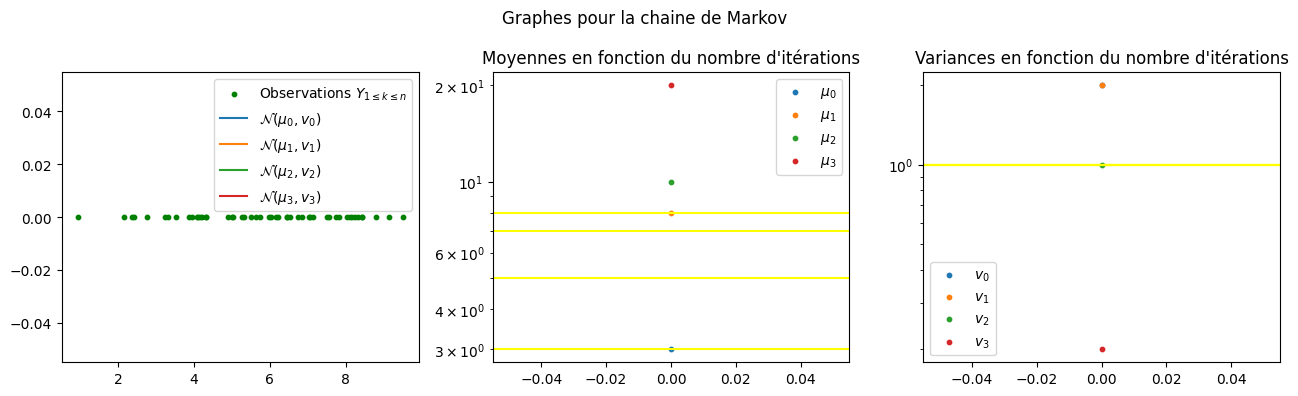

In [2936]:
""" Chaine de markov 2 """
Q = np.array([[0,1,0,0],[0,0,1,0],[0,0,0,1],[1,0,0,0]])
nu = np.array([1/4,1/4,1/4,1/4])
E = np.array([1,2,3,4])
nb_observations = 50
means = np.array([5,8,3,7])
vars = np.array([1,1,1,1])
X = Simulation(Q,nu,E,nb_observations)
Y = Simulation_Observation(X,means,vars)

means_init = np.array([3.,8.,10.,20.])
vars_init = np.array([2.,2.,1.,0.2])
nb_iters = 50

theta_init = (Q,nu,means_init,vars_init)

means_result,vars_result,liste_means,liste_vars = EM_test_simple(Y,theta_init,nb_iters,X)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")

affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)

<font color=red> On met à jours toutes les observations </font>

#### <font color=darkorange>  IIII - Méthode de Gradient </font>


\begin{equation*}
\begin{aligned}
\nu_i^{\theta} &\leftarrow \nu_i^{\theta} + \alpha \sum_{k=0}^n \omega_k^{\theta\prime}(i) \ \newline
\mu_i^{\theta} &\leftarrow \mu_i^{\theta} + \alpha \sum_{k=0}^n \frac{(y_k - \mu_i^{\theta})\omega_k^{\theta\prime}(i)}{v_i^{\theta}} \ \newline
v_i^{\theta} &\leftarrow v_i^{\theta} + \alpha \left(\sum_{k=0}^n \frac{\omega^{\theta\prime}_{k}(i)}{v_i^{\theta}} - \sum_{k=0}^n \frac{(y_k - \mu_i^{\theta})\omega_k^{\theta\prime}(i)}{(v_i^{\theta})^2}\right) \ \newline
q_{i j}^{\theta} &\leftarrow q_{i j}^{\theta} + \alpha \sum_{k=0}^{n-1} \omega_{k,k+1}^{\theta\prime}(i,j)
\end{aligned}
\end{equation*}

Note : Le symbole $\alpha$ représente le taux d'apprentissage (learning rate) de la méthode de gradient et $\omega^{\theta\prime}$ représente la distribution des variables latentes dans le modèle.



In [2937]:
def descente_gradient(Y,Q_init,nu_init,means_init,vars_init,nb_iters):
    n = Y.size
    r = nu_init.size 
    y = Y
    Q = Q_init
    nu = nu_init
    means = means_init
    vars = vars_init
    print(vars)
    for k in range(nb_iters): # mise à jour de la moyenne
        omega = omega_now(y,Q,nu,means,vars) 
        for i in range(r):
            print(vars)
            means[i] = means[i] + 0.01 * np.sum( (y-means[i]) * omega[:,i] ) / (vars[i])
            vars[i] = vars[i] - 0.01 * ( (np.sum(omega[:,i])) / (2*vars[i]) - np.sum( ((y-means[i]) * omega[:,i])**2 )  / (2 *(vars[i])**2))
            print(vars)
    return means,vars

descente_gradient(Y,Q,nu,means_init,vars_init,nb_iters)


[nan nan nan nan]


TypeError: omega_now() takes 2 positional arguments but 5 were given